In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import warnings

In [2]:
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Preprocessing

In [3]:
train_path = "resources/dataset/train/"
test_path = "resources/dataset/test/"

In [4]:
train_dir = os.listdir(train_path)

In [5]:
ocean_train = os.listdir(train_path + "sea_ocean")
other_train = os.listdir(train_path + "other")
ocean_test = os.listdir(test_path + "sea_ocean")
other_test = os.listdir(test_path + "other")

In [6]:
heights = []
width = []
all_img = []

for img in ocean_train:
    img = Image.open(train_path + "sea_ocean/" + img)
    w, h = img.size
    heights.append(h)
    width.append(w)
    all_img.append(np.array(img))

for img in other_train:
    img = Image.open(train_path + "other/" + img)
    w, h = img.size
    heights.append(h)
    width.append(w)
    all_img.append(np.array(img))


In [7]:
mean_h = int(np.mean(heights))
mean_w = int(np.mean(width))
print(mean_h, mean_w)

413 657


Text(0, 0.5, 'Width')

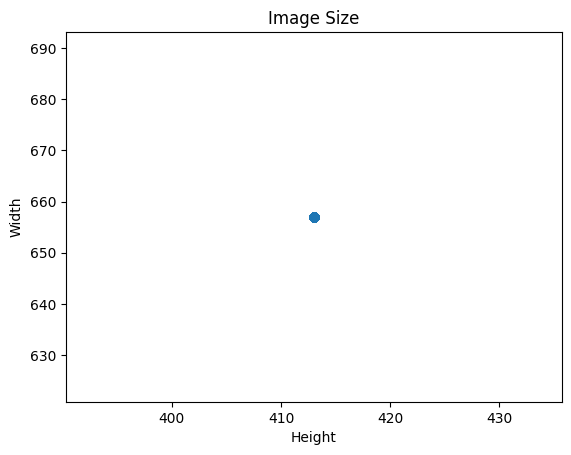

In [8]:
plt.scatter(heights, width)
plt.title("Image Size")
plt.xlabel("Height")
plt.ylabel("Width")

In [9]:
def normalise(repo_path, img_repo, class_name):
    for img in img_repo:
        name = img
        img = Image.open(repo_path + class_name + "/" + name)
        img = img.resize((int(mean_w), int(mean_h)))
        img = np.array(img)
        try:
            img = img[:, :, :3]
        except:
            print(name + " from " + str(repo_path))
        img = img[:, :, :3]
        img = Image.fromarray(img)
        img.save(f"{repo_path}{class_name}/{name}")

In [10]:
normalise(repo_path=train_path, img_repo=ocean_train, class_name="sea_ocean")
normalise(repo_path=train_path, img_repo=other_train, class_name="other")
normalise(repo_path=test_path, img_repo=ocean_test, class_name="sea_ocean")
normalise(repo_path=test_path, img_repo=other_test, class_name="other")

# Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1/255.0
)

In [13]:
test_data_generator = ImageDataGenerator(rescale=1/255.0)
#train_data_generator = ImageDataGenerator(rescale=1/255.0)

# ImageDataGenerator

In [14]:
train_generator = train_data_generator.flow_from_directory(
    directory = train_path,
    target_size = (mean_w, mean_h),
    batch_size=32,
    class_mode="binary"

)

test_generator = test_data_generator.flow_from_directory(
    directory = test_path,
    target_size = (mean_w, mean_h),
    batch_size=32,
    class_mode="binary"
)

Found 294 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [15]:
train_generator.class_indices

{'other': 0, 'sea_ocean': 1}

In [16]:
mean_w, mean_h

(657, 413)

# Model

In [17]:
def plot_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(list(range(len(history['loss']))), history['loss'], label = "loss")
    ax[0].plot(list(range(len(history['val_loss']))), history['val_loss'], label="val_loss")
    ax[0].set(xlabel="Epochs", ylabel="Loss")
    ax[0].set_title("Loss Curve")
    ax[0].legend(loc='upper right')
    ax[1].plot(list(range(len(history['accuracy']))), history['accuracy'], label = "accuracy")
    ax[1].plot(list(range(len(history['val_accuracy']))), history['val_accuracy'], label="val_accuracy")
    ax[1].set(xlabel="Epochs", ylabel="Accuracy")
    ax[1].set_title("Accuracy Curve")
    ax[1].legend(loc='upper right')

In [18]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(mean_h, mean_w, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    # Dense
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
                ])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 413, 657, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 206, 328, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 202, 324, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 101, 162, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 158, 128)      204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 79, 128)      0

In [20]:
h = model.fit(train_generator, epochs=50,
             validation_data=test_generator,
              callbacks=[model_ckp, stop]
             )

Epoch 1/50
10/10 [==============================] - 36s 2s/step - loss: 0.8396 - accuracy: 0.5544 - val_loss: 1.2115 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 10s 979ms/step - loss: 0.6182 - accuracy: 0.6939 - val_loss: 0.4800 - val_accuracy: 0.7759
Epoch 3/50
10/10 [==============================] - 10s 973ms/step - loss: 0.5449 - accuracy: 0.7041 - val_loss: 0.4715 - val_accuracy: 0.8448
Epoch 4/50
10/10 [==============================] - 10s 899ms/step - loss: 0.5212 - accuracy: 0.7789 - val_loss: 0.4350 - val_accuracy: 0.8190
Epoch 5/50
10/10 [==============================] - 10s 1s/step - loss: 0.5433 - accuracy: 0.7551 - val_loss: 0.5477 - val_accuracy: 0.6983
Epoch 6/50
10/10 [==============================] - 10s 949ms/step - loss: 0.5037 - accuracy: 0.7891 - val_loss: 0.5568 - val_accuracy: 0.7672


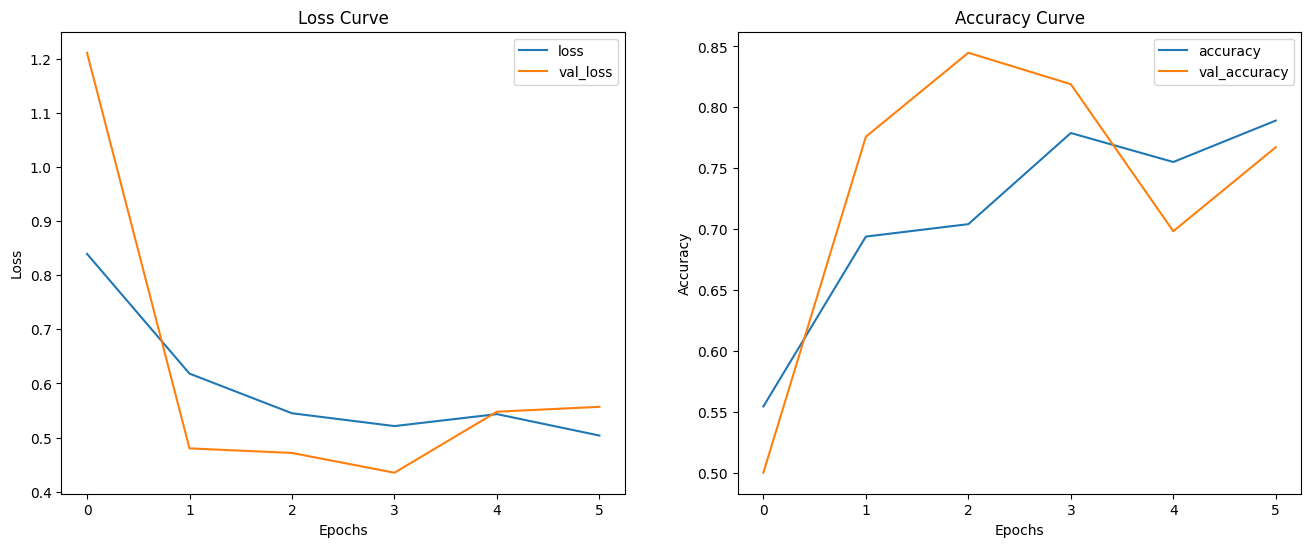

In [21]:
plot_curves(h.history)

In [22]:
model1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu',
                           input_shape=(mean_h, mean_w, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="model1.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 413, 657, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 206, 328, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 202, 324, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 101, 162, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 158, 128)      204928    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 79, 128)     

Epoch 1/50
10/10 [==============================] - 10s 933ms/step - loss: 3.3194 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 10s 949ms/step - loss: 0.7028 - accuracy: 0.4932 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 3/50
10/10 [==============================] - 10s 946ms/step - loss: 0.6894 - accuracy: 0.4932 - val_loss: 0.6761 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 10s 972ms/step - loss: 0.6810 - accuracy: 0.5646 - val_loss: 0.6668 - val_accuracy: 0.5948
Epoch 5/50
10/10 [==============================] - 10s 971ms/step - loss: 0.6458 - accuracy: 0.5952 - val_loss: 0.6700 - val_accuracy: 0.6552
Epoch 6/50
10/10 [==============================] - 10s 954ms/step - loss: 0.6633 - accuracy: 0.6939 - val_loss: 0.6438 - val_accuracy: 0.6552
Epoch 7/50
10/10 [==============================] - 10s 974ms/step - loss: 0.6676 - accuracy: 0.6020 - val_loss: 0.6382 - val_accuracy: 0.7845

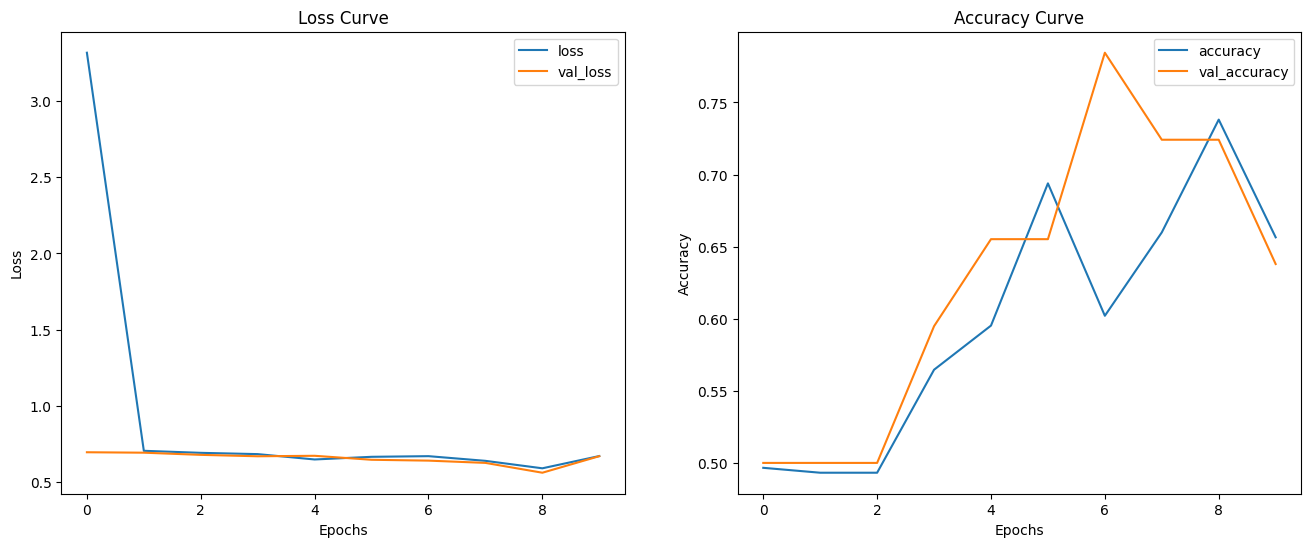

In [24]:
h1 = model1.fit(train_generator, epochs=50,
              validation_data=test_generator,
                callbacks=[model_ckp, stop])
plot_curves(h1.history)

In [25]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu',
                           input_shape=(mean_h, mean_w, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss="binary_crossentropy",
               metrics=['accuracy'])
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath="model2.h5",
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [26]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 413, 657, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 206, 328, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 202, 324, 64)      51264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 101, 162, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 158, 64)       102464    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 79, 64)      

Epoch 1/50
10/10 [==============================] - 15s 1s/step - loss: 1.0611 - accuracy: 0.5000 - val_loss: 0.6198 - val_accuracy: 0.7414
Epoch 2/50
10/10 [==============================] - 10s 935ms/step - loss: 0.5744 - accuracy: 0.7313 - val_loss: 0.5636 - val_accuracy: 0.7155
Epoch 3/50
10/10 [==============================] - 10s 926ms/step - loss: 0.5838 - accuracy: 0.7177 - val_loss: 0.5548 - val_accuracy: 0.7586
Epoch 4/50
10/10 [==============================] - 10s 931ms/step - loss: 0.5512 - accuracy: 0.7517 - val_loss: 0.4490 - val_accuracy: 0.8103
Epoch 5/50
10/10 [==============================] - 10s 927ms/step - loss: 0.5290 - accuracy: 0.7653 - val_loss: 0.6482 - val_accuracy: 0.5603
Epoch 6/50
10/10 [==============================] - 10s 928ms/step - loss: 0.5549 - accuracy: 0.7109 - val_loss: 0.5657 - val_accuracy: 0.7414
Epoch 7/50
10/10 [==============================] - 10s 930ms/step - loss: 0.5445 - accuracy: 0.7449 - val_loss: 0.5147 - val_accuracy: 0.7500
Ep

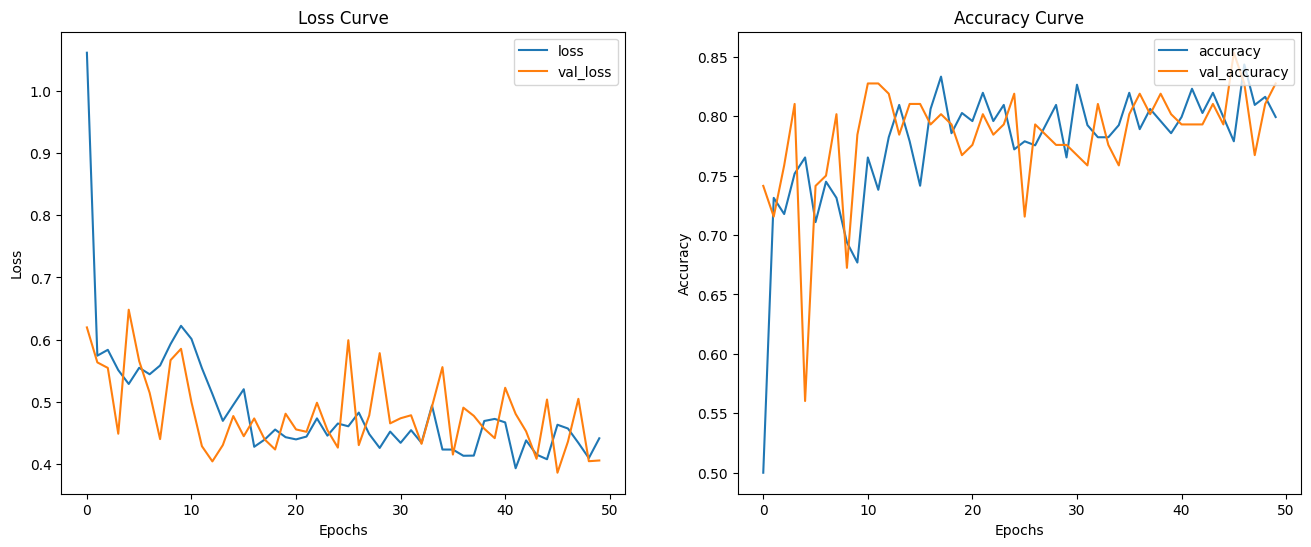

In [28]:
h2 = model2.fit(train_generator, epochs=50,
                validation_data=test_generator,
                )
plot_curves(h2.history)

# Fine Tuning Resnet

In [ ]:
#plot_curves(h.history)

# Prediction

In [ ]:
img_test = "resources/IMG_0245.JPG"
img1_test = "C:/Users/thorr/OneDrive/Images/IMG_0067.JPG"
land = "resources/landscape.jpeg"
img2_test = "C:/Users/thorr/OneDrive/Images/IMG_0106.JPG"

In [ ]:
def get_predict(path):
    img = Image.open(path)
    img = img.resize((mean_h, mean_w))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    prediction = model.predict(img)
    return prediction

In [ ]:
get_predict(img1_test)

In [ ]:
get_predict(img_test)

In [ ]:
get_predict(land)

In [ ]:
get_predict(img2_test)